### Initial set-up

In [1]:
# Specify if user is working on Google Drive
google_drive = False

In [2]:
if google_drive == True:
    
    from google.colab import drive 
    drive.mount('/content/drive')
    
    path = "./drive/MyDrive/TFM"
    
    import sys
    sys.path.append(path)

else:
    path = "."
    
    import sys
    sys.path.append(path)

#### Google Colab TPU session

In [3]:
# Specify if user is working on a TPU session in Google Colab
tpu_session = False

In [4]:
if tpu_session == True:
    
    %tensorflow_version 2.x
    import tensorflow as tf
    print("Tensorflow version " + tf.__version__)

    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
else:
    pass

### Import libraries

In [5]:
import os
import numpy as np
import pandas as pd
import pickle
import time
import cv2

# Import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
#import tensorflow.keras.activations as Activations
#import tensorflow.keras.optimizers as Optimizer
#import tensorflow.keras.metrics as Metrics
#import tensorflow.keras.utils as Utils
#from tensorflow.keras.constraints import max_norm

# Import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

# Import visualization packages
from matplotlib import image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(context='notebook')
sns.set_style("ticks")

# Extra utils
from aux_functions.aux_functions_cnn import *

#from sklearn.utils import shuffle
#from random import randint
#from IPython.display import SVG
#import matplotlib.gridspec as gridspec

### Load dataset

#### Specify dataset path

In [6]:
# Specify folders where there are the 2D images of the brain
root_png_images = path + "/datasets/New_png_images"

#### Load 2D images
**NOTE: It takes around 18 minutes to load all 2D images (3287) using TPU session in Google Colab**

In [7]:
# Initiliaze lists
images = []  # List where to save the images
titles = []  # List where to save the name of the images (Image ID)

# Load images
for index,file in enumerate(os.listdir(root_png_images)):
  
    # Avoid trigerring .DS_Store (when use macOS)
    if file.startswith('.DS_Store'):
        continue
            
    # Read image
    img = cv2.imread(os.path.join(root_png_images,file), cv2.IMREAD_UNCHANGED)
    
    # Resize image
    # https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/
    # https://enmilocalfunciona.io/tratamiento-de-imagenes-usando-imagedatagenerator-en-keras/
    dim = (320, 240)
    resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    # Convert image from RGBA2RGB
    if len(resized_img.shape) > 2 and resized_img.shape[2] == 4:
        resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGRA2BGR)
        
    # Get title of the image
    title = file.split(".")[0]
    
    # Append image & title to lists  
    images.append(resized_img)
    titles.append(title)
  
    if index == 999:
        break

# Check number of images loaded
print("[+] Number of images loaded:", len(images))
print("[+] Number of titles loaded:", len(titles))

[+] Number of images loaded: 350
[+] Number of titles loaded: 350


[+] Shape image: (240, 320, 3)


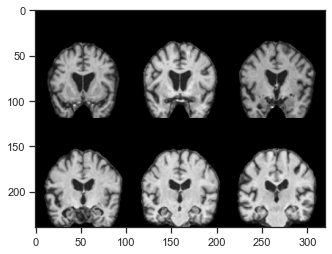

In [8]:
# Show image
image_ = images[10]
print("[+] Shape image:", image_.shape)
plt.imshow(image_);

#### Load CSV files with image details

In [9]:
# Load individuals CSV files with image details
df_1 = pd.read_csv(path + "/datasets/ADNI1_Complete_1Yr_1.5T.csv")
df_2 = pd.read_csv(path + "/datasets/ADNI1_Complete_2Yr_1.5T.csv")
df_3 = pd.read_csv(path + "/datasets/ADNI1_Complete_3Yr_1.5T.csv")

# Concatenate all CSV files in a unique dataframe
df = pd.concat([df_1, df_2, df_3])

# Remove extra whitespaces from column names
df.columns = df.columns.str.replace(" ", "")

df.head()

,ImageDataID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,AcqDate,Format,Downloaded
0,I125941,137_S_1426,MCI,M,85,4,MRI,MPR-R; GradWarp; N3; Scaled,Processed,10/30/2008,NiFTI,NaN
1,I121703,128_S_1408,MCI,M,73,4,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,9/19/2008,NiFTI,NaN
2,I121637,037_S_1421,MCI,F,76,4,MRI,MPR; GradWarp; N3; Scaled,Processed,9/17/2008,NiFTI,NaN
3,I122382,128_S_1407,MCI,F,76,4,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,9/05/2008,NiFTI,NaN
4,I121689,127_S_1427,MCI,F,71,4,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,9/02/2008,NiFTI,NaN


In [10]:
# Retrieve only the image ID and Group (class) columns
df = df[["ImageDataID", "Group"]]
df.head()

,ImageDataID,Group
0,I125941,MCI
1,I121703,MCI
2,I121637,MCI
3,I122382,MCI
4,I121689,MCI


In [11]:
# Check number of cases by class in the dataframe
df["Group"].value_counts()

MCI    1708
CN     1009
AD      575
Name: Group, dtype: int64

It can be seen that the three following classes are presented in the dataset:
   - **MCI** - Mild cognitive impairment patients
   - **CN** - Cognitively normal patients
   - **AD** - Alzheimer’s disease patients

In [12]:
# Retrieve class for each image mapping the titles list and the Image ID column from the dataframe
y = []  # List where to save the class for each image: 1 (AD, MCI), 0 (CN)

for title in titles:
    group_ = df["Group"].loc[df['ImageDataID'] == title].values[0]
    
    if group_ in ["AD","MCI"]:
        y.append(1)
        
    elif group_ in ["CN"]:
        y.append(0)
        
    else:
        y.append(False)

# # Check number of cases by class with images loaded
print(f"[+] Number of Alzheimer cases: {y.count(1)}")
print(f"[+] Number of healthy cases: {y.count(0)}")

[+] Number of Alzheimer cases: 178
[+] Number of healthy cases: 172


In [13]:
# Convert X and y lists to arrays
X = images
X = np.asarray(X).astype('int8')

y = np.array(y)

In [14]:
# Check minimum and maximum value of X data
print(f"[+] Minimum value of X data: {np.amin(X)}")
print(f"[+] Maximum value of X data: {np.amax(X)}")

[+] Minimum value of X data: -128
[+] Maximum value of X data: 127


It can be seen how images pixel values range from -128 to +127.
In order to facilitate training, a normalization is carried out.

In [15]:
# Normalizing X data
max_value = max(abs(int(np.amin(X))), abs(int(np.amax(X))))
X = X / max_value

print(f"[+] Minimum value of X data after normalization: {np.amin(X)}")
print(f"[+] Maximum value of X data after normalization: {np.amax(X)}")

[+] Minimum value of X data after normalization: -1.0
[+] Maximum value of X data after normalization: 0.9921875


#### Save images and classes
Only run the next two cells if you want to save both X and y arrays into numpy files.

In [ ]:
# Save list of images as a numpy file
np.savez_compressed("images", X)

In [ ]:
# Save list of classes as a numpy file
np.savez_compressed("classes", y)

#### Load images and classes
Only run the next two cells if you want to load both X and y arrays from numpy files.

In [ ]:
# Load images in array format
loaded_images = np.load('images.npz', allow_pickle= True)
X = loaded_images['arr_0']

In [ ]:
# Load classes in array format
loaded_classes = np.load('classes.npz', allow_pickle= True)
y = loaded_classes['arr_0']

#### Get training and testing datasets

In [16]:
# Define testing proportion of the dataset
test_size = 0.3

# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)

# Print data shapes
print(f"[+] Training shape: {len(X_train)}")
print(f"    [-] Number of Alzheimer cases: {round(sum(y_train))}")
print(f"    [-] Number of healthy cases: {round(len(y_train) - sum(y_train))}")
print(f"\n[+] Testing shape: {len(X_test)}")
print(f"    [-] Number of Alzheimer cases: {round(sum(y_test))}")
print(f"    [-] Number of healthy cases: {round(len(y_test) - sum(y_test))}")

[+] Training shape: 245
    [-] Number of Alzheimer cases: 114
    [-] Number of healthy cases: 131

[+] Testing shape: 105
    [-] Number of Alzheimer cases: 64
    [-] Number of healthy cases: 41


### Define CNN model

In [17]:
def build_model(input_shape_):
    '''
    Function to build a convolutional neural network.
    Inputs: input shape
    '''

    # Fix random seed for reproducibility
    np.random.seed(123)
    tf.random.set_seed(123) 

    # Start Sequential model
    model = Sequential()
    
    # Input layer
    model.add(InputLayer(input_shape = input_shape_))
              
    # Convolutional layers  
    ## 1st conv block
    model.add(Conv2D(50, kernel_size=(3,3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    ## 2nd conv block
    model.add(Conv2D(75, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    ## 3rd conv block
    model.add(Conv2D(125, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
      
    # Flatten layer
    model.add(Flatten())
              
    # Hidden layers       
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

In [18]:
# Build model
input_shape_ = (240, 320, 3)
model = build_model(input_shape_)
#model.summary()

### Train CNN model

In [19]:
# Define Hyperparameters  
batch_size = 64
num_epochs = 10
steps_per_epoch = int(len(X_train) * 0.85/ batch_size)
validation_split = 0.3
validation_steps = int(len(X_train) * validation_split / batch_size)

In [20]:
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 3
Validation steps: 1


In [21]:
# Define learning rate
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, 
                                                          decay_steps = 100000, 
                                                          decay_rate = 0.96, 
                                                          staircase = True)

# Compile model
model.compile(loss = 'binary_crossentropy', 
              optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), 
              metrics = [f1]) 

In [22]:
# Train model
start_time = time.time()

history = model.fit(x = X_train, 
                    y = y_train,
                    epochs = num_epochs,
                    validation_split = validation_split,
                    verbose = 1)

end_time = time.time()
print("[+] Time of training: "+"{:.2f}".format(end_time-start_time));

Epoch 1/10
6/6 [==============================] - 30s 5s/step - loss: 1.8282 - f1: 0.2585 - val_loss: 0.6821 - val_f1: 0.2159
Epoch 2/10
6/6 [==============================] - 27s 4s/step - loss: 2.2112 - f1: 0.4100 - val_loss: 0.6838 - val_f1: 0.4785
Epoch 3/10
6/6 [==============================] - 26s 4s/step - loss: 1.6633 - f1: 0.5174 - val_loss: 0.6842 - val_f1: 0.1094
Epoch 4/10
6/6 [==============================] - 27s 4s/step - loss: 1.4622 - f1: 0.4510 - val_loss: 0.6832 - val_f1: 0.6711
Epoch 5/10
6/6 [==============================] - 26s 4s/step - loss: 1.0394 - f1: 0.4985 - val_loss: 0.6882 - val_f1: 0.6761
Epoch 6/10
6/6 [==============================] - 26s 4s/step - loss: 1.1381 - f1: 0.3934 - val_loss: 0.6936 - val_f1: 0.6711
Epoch 7/10
6/6 [==============================] - 27s 4s/step - loss: 1.0637 - f1: 0.5129 - val_loss: 0.6940 - val_f1: 0.6208
Epoch 8/10
6/6 [==============================] - 27s 4s/step - loss: 0.8032 - f1: 0.5090 - val_loss: 0.6919 - val_f1:

### Evaluation 

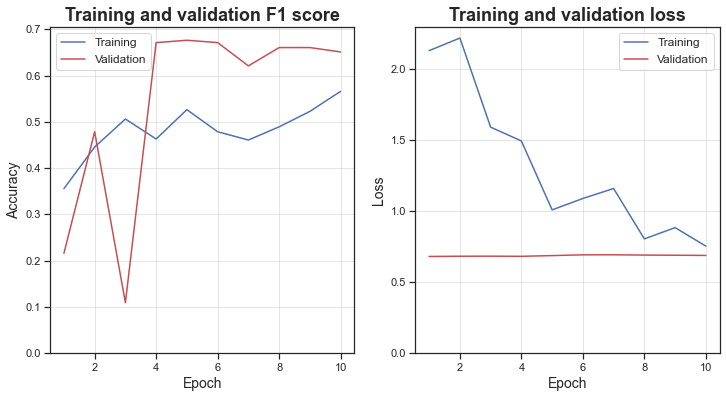

In [23]:
# Plot metrics
plot_history_2(history)

In [ ]:
# Get accuracy
model.evaluate(x = X_test,
               y = y_test, 
               verbose = 0)

In [24]:
# Get predictions
fn_sensitive = 0.5  # False negative sensitive variable
y_predict = []

for sample in model.predict(X_test):
    if sample < fn_sensitive:
        y_predict.append(0)
    else:
        y_predict.append(1)

Recall: 0.97
Precision: 0.61
F1 score: 0.75


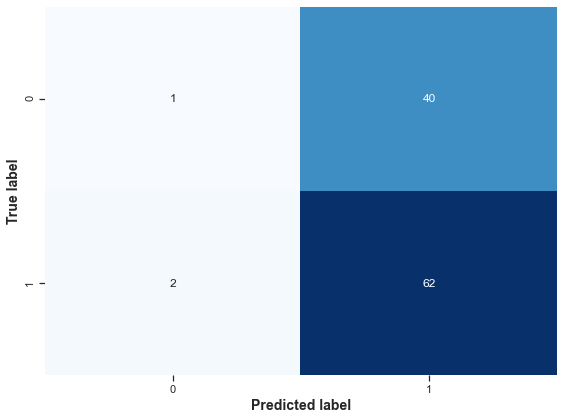

In [25]:
# Evaluation
print("Recall: "+"{:.2f}".format(recall_score(y_test, y_predict)))
print("Precision: "+"{:.2f}".format(precision_score(y_test, y_predict)))
print("F1 score: "+"{:.2f}".format(f1_score(y_test, y_predict)))
            
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="",cmap="Blues",cbar=False)
plt.xlabel('Predicted label', fontsize= 14,fontweight='bold')
plt.ylabel('True label', fontsize= 14, fontweight='bold') 
plt.tight_layout()
plt.show()

[+] Train AUC score = 0.772
[+] Test AUC score = 0.568


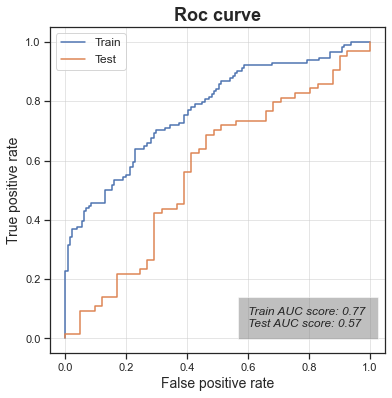

In [26]:
# Plot roc curve
plot_roc_curve(model, X_train, X_test, y_train, y_test, save_fig = False)

#### Save CNN model

In [ ]:
# Save model
model.save(path + "/cnn_model_1.h5")
print("\n[+] Model saved")

===================================================================================================================
#==================================================================================================================
### OTHERS

In [ ]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(240, 320, 3), 
    weights='imagenet', 
    include_top=False,
    pooling='max')

base_output = base_model.output
hidden_layer = tf.keras.layers.Dense(512, activation='relu')(base_output)
hl_reg = tf.keras.layers.Dropout(0.8)(hidden_layer)
output_layer = tf.keras.layers.Dense(1, activation='softmax')(hl_reg)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
              metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
# Hyperparameters
dropout = 0.1
mn_value = 0.5

# Start model
m = Models.Sequential()

# Input layer
m.add(Layers.Flatten(input_shape=(240, 320, 3)))

# Hidden layers
m.add(Layers.Dense(units=10, activation = "relu", kernel_constraint=max_norm(mn_value)))
m.add(Layers.Dense(units=10, activation = "relu", kernel_constraint=max_norm(mn_value)))
m.add(Layers.Dense(units=10, activation = "relu", kernel_constraint=max_norm(mn_value)))
m.add(Layers.Dropout(rate = dropout))

# Output layer
m.add(Layers.Dense(1,activation='sigmoid'))

# Compile model
m.compile(optimizer = "adam" ,
          loss = "binary_crossentropy",
          metrics = ["accuracy"]

In [ ]:
int(len(list(history.history.keys())) / 2)

In [ ]:
a = [0,1,2,3]

In [ ]:
int(len(list(history.history.keys())) / 2)

keys_ = list(history.history.keys())[:2]
keys_    


limit_ = int(len(list(history.history.keys()))/2)
keys_ = list(history.history.keys())[:limit_]